In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100].copy()
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1].copy()
            ldms_dataframe.loc[:, metric] = ldms_dataframe[metric] * 100
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_nvlink = pd.read_parquet(csv_filepath + "/" + "dcgm.nvlink_bandwidth_total.1692169200.1692428399.8.16_ldms.pq")
df_sacct_nvlink = pd.read_parquet(csv_filepath + "/" + "dcgm.nvlink_bandwidth_total.1692169200.1692428399.8.16_saact.pq")
merged_ldms_nvlink = preprocess_data(df_nvlink, df_sacct_nvlink, metric="nvlink_bandwidth_total", percentage=False)

Number of LDMS data points before preprocessing:  116807425
Number of LDMS data points after preprocessing:  52270459


In [6]:
merged_ldms_nvlink = merged_ldms_nvlink[merged_ldms_nvlink["Account"].str.contains("_g")]

#### Number of jobs that use FP16

In [7]:
jobs_without_zero_nvlink = merged_ldms_nvlink.groupby('jobid').filter(lambda x: x['nvlink_bandwidth_total'].sum() != 0)
num_nvlink_jobs = jobs_without_zero_nvlink['jobid'].nunique()
print(f"Number of jobs that use NVLINK: {num_nvlink_jobs}")
print("Total number of jobs: ", merged_ldms_nvlink[["jobid"]].nunique())

Number of jobs that use NVLINK: 6744
Total number of jobs:  jobid    15525
dtype: int64


#### Node hours of jobs that use FP16

In [8]:
unique_jobs_without_zero_nvlink = jobs_without_zero_nvlink.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_nvlink['duration_hours'] = unique_jobs_without_zero_nvlink['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_nvlink['node_hours'] = unique_jobs_without_zero_nvlink['nnodes'] * unique_jobs_without_zero_nvlink['duration_hours']

total_node_hours_nvlink = unique_jobs_without_zero_nvlink['node_hours'].sum()
print(f"Total node hours of jobs that use NVLINK: {total_node_hours_nvlink}")

Total node hours of jobs that use NVLINK: 20684.328055555554


#### CDF and PDF

In [23]:
# TODO

#### Summary of statistics (Find better ways to do this)

51310

41782

69834

28292

96260

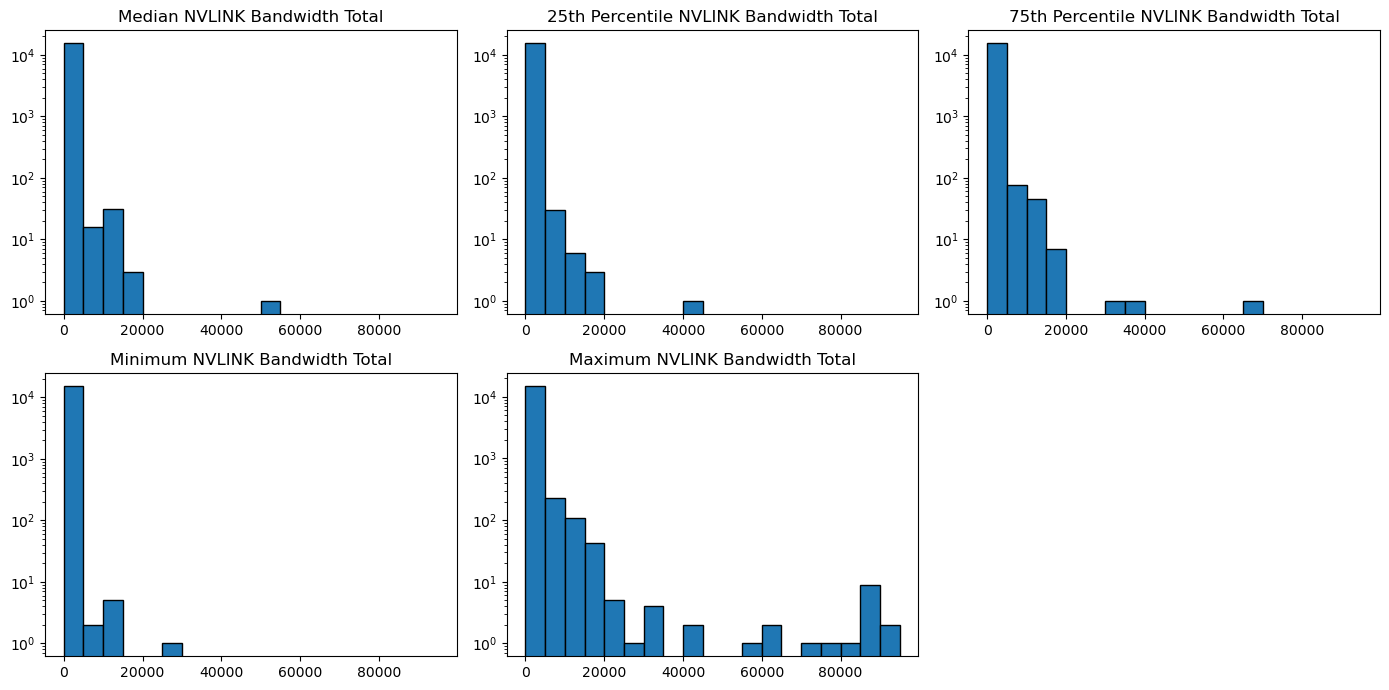

In [15]:
summary_stats = merged_ldms_nvlink.groupby('jobid')['nvlink_bandwidth_total'].describe(percentiles=[.25, .5, .75]).reset_index()

plt.figure(figsize=(14, 7))

max_50 = summary_stats['50%'].max()
max_50 = int(max_50)
display(max_50)
bins = range(0, 100000, 5000) 
plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median NVLINK Bandwidth Total')

plt.subplot(2, 3, 2)
max_25 = summary_stats['25%'].max()
max_25 = int(max_25)
display(max_25)
bins = range(0, 100000, 5000) 
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th Percentile NVLINK Bandwidth Total')

plt.subplot(2, 3, 3)
max_75 = summary_stats['75%'].max()
max_75 = int(max_75)
display(max_75)
bins = range(0, 100000, 5000) 
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th Percentile NVLINK Bandwidth Total')

plt.subplot(2, 3, 4)
max_min = summary_stats['min'].max()
max_min = int(max_min)
display(max_min)
bins = range(0, 100000, 5000) 
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum NVLINK Bandwidth Total')

plt.subplot(2, 3, 5)
max_max = summary_stats['max'].max()
max_max = int(max_max)
display(max_max)
bins = range(0, 100000, 5000) 
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum NVLINK Bandwidth Total')

plt.tight_layout()
plt.show()

In [11]:
summary_stats

,jobid,count,mean,std,min,25%,50%,75%,max
0,3366460,154.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,3368245,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
2,5360505,8598.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,5811681,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
4,6917159,103515.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15520,14068349,116.0,568.508621,386.584408,0.0,0.0,763.0,772.0,1664.0
15521,14068350,1004.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
15522,14068352,112.0,444.062500,409.945905,0.0,0.0,733.0,749.0,1509.0
15523,14068358,108.0,485.537037,378.331962,0.0,0.0,689.0,698.0,1510.0
